# Cucumber or courgette?

Whilst following the fast.ai course, Jeremy mentioned that a student had trained a cumcumber vs courgette classifier. I thought that was cool, so I'm going to give it a try using some of the tools from Lessons 1 & 2.

As much as this makes me uncomfortable, Jeremy assures me that `from fastai import *` will work perfectly fine and is designed that way. Who am I to argue?

In [1]:
from fastai.vision import *

Following the instructions from url, I went to google images and used this code snippet 
```javascript
urls=Array.from(document.querySelectorAll('.rg_i')).map(el=> el.hasAttribute('data-src')?el.getAttribute('data-src'):el.getAttribute('data-iurl'));
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));
```
to download some images of cucumbers and courgettes and uploaded them onto my Google Cloud instance.

In [2]:
path = Path('/home/jupyter/my-datasets/cucumbers-courgettes')

In [14]:
path.ls()

[PosixPath('/home/jupyter/my-datasets/cucumbers-courgettes/cucumbers'),
 PosixPath('/home/jupyter/my-datasets/cucumbers-courgettes/courgettes'),
 PosixPath('/home/jupyter/my-datasets/cucumbers-courgettes/cucumbers-urls.txt'),
 PosixPath('/home/jupyter/my-datasets/cucumbers-courgettes/courgettes-urls.txt'),
 PosixPath('/home/jupyter/my-datasets/cucumbers-courgettes/models')]

In [4]:
download_images(path/'cucumbers-urls.txt', path/'cucumbers', max_pics=300)

In [5]:
download_images(path/'courgettes-urls.txt', path/'courgettes', max_pics=300)

Now remove any images that can't be opened

In [6]:
classes = ['cucumbers', 'courgettes']

In [7]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

cucumbers


courgettes


## View data

In [34]:
# I ran this after the initial data pull
# np.random.seed(42)
# data = ImageDataBunch.from_folder(path, valid_pct=0.2, ds_tfms=get_transforms(), 
#                                   size=224, num_workers=4).normalize(imagenet_stats)

In [40]:
# After data cleaning
data = ImageDataBunch.from_csv(path, folder=".", valid_pct=0.2, csv_labels='cleaned.csv',
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [41]:
data.classes

['courgettes', 'cucumbers']

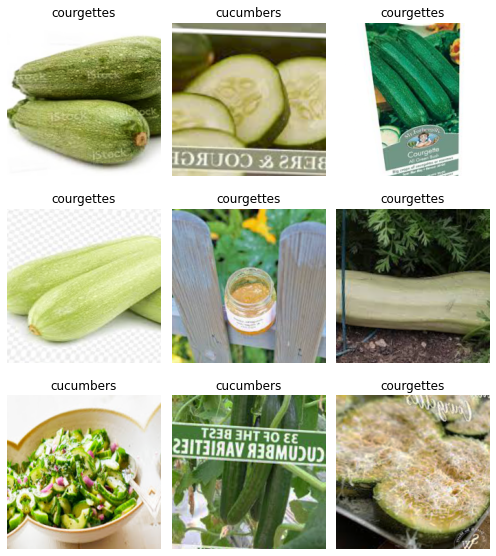

In [42]:
data.show_batch(rows=3, figsize=(7,8))

In [43]:
data

ImageDataBunch;

Train: LabelList (414 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
cucumbers,cucumbers,cucumbers,cucumbers,cucumbers
Path: /home/jupyter/my-datasets/cucumbers-courgettes;

Valid: LabelList (103 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
cucumbers,courgettes,courgettes,courgettes,courgettes
Path: /home/jupyter/my-datasets/cucumbers-courgettes;

Test: None

## Train model

In [44]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [45]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.167135,1.438177,0.427184,00:02
1,0.835233,1.272639,0.320388,00:02
2,0.649208,0.566371,0.184466,00:02
3,0.553855,0.499614,0.165049,00:02


In [46]:
learn.save('stage-1')

In [47]:
learn.unfreeze()

In [48]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Hmmm not sure why `valid_loss` is `#na#` but let's roll with it

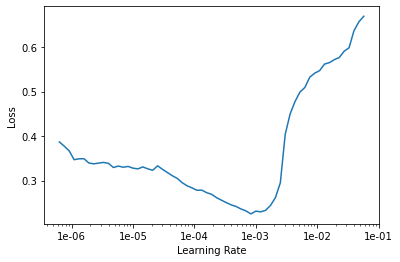

In [49]:
learn.recorder.plot()

In [50]:
learn.fit_one_cycle(2, max_lr=slice(1e-4, 3e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.382020,1.059163,0.223301,00:02
1,0.310805,0.715075,0.174757,00:02


In [51]:
learn.save('stage-2')

# Interpretation

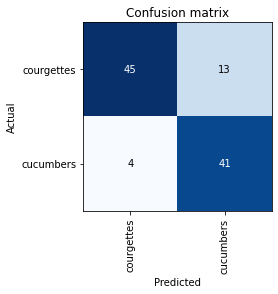

In [73]:
learn.load('stage-1');

interp = ClassificationInterpretation.from_learner(learn)

interp.plot_confusion_matrix()

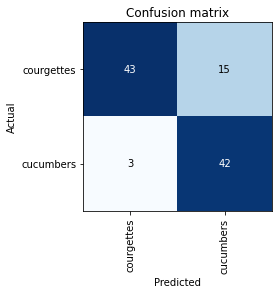

In [72]:
learn.load('stage-2');

interp = ClassificationInterpretation.from_learner(learn)

interp.plot_confusion_matrix()

So the second stage of learning didn't seem to do a great deal.

When it's really a courgette, we're more likely to struggle classifying. I can see where it's coming from there...

In [74]:
interp = ClassificationInterpretation.from_learner(learn)

losses, idxs = interp.top_losses()

len(data.valid_ds) == len(losses) == len(idxs)

True

In [75]:
doc(interp.plot_top_losses)

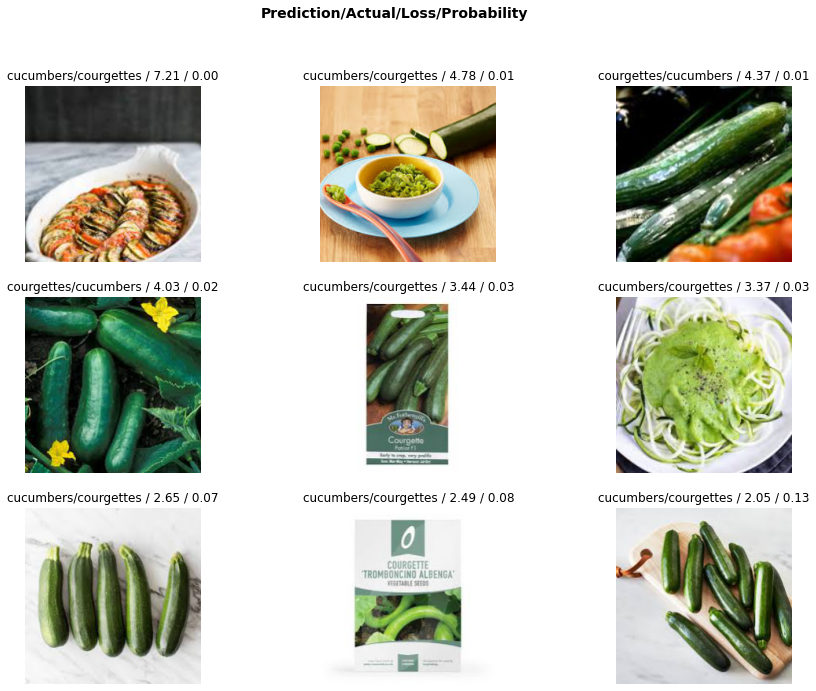

In [77]:
interp.plot_top_losses(9, figsize=(15,11))

Some of the dishes are hard to predict which is fair enough. I guess this is a pretty hard problem, even I strain on some of these to tell if it's a courgette!

## Let's try and overfit

In [61]:
learn.load('stage-1');

In [64]:
learn.freeze();

In [65]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.327504,0.706259,0.203883,00:02
1,0.314347,0.637883,0.184466,00:02
2,0.300797,0.549173,0.194175,00:02
3,0.285913,0.529457,0.194175,00:02


So 4 epochs was actually ok, because the validation loss immediately got larger (it was `0.499614`)

In [66]:
learn.load('stage-1');

In [67]:
learn.unfreeze();

In [68]:
learn.fit_one_cycle(4, max_lr=slice(1e-4, 3e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.393179,0.819694,0.203883,00:02
1,0.314094,0.917609,0.242718,00:02
2,0.236526,0.669327,0.165049,00:02
3,0.198704,0.627935,0.145631,00:02


So just training the final layer for 4 epochs seemed to work the best.

---

## Cleaning up

Some of the top losses are likely due to bad validation data rather than the model being bad.

Use `ImageCleaner` to prune the top losses away to remove photos that don't belong.

In [30]:
from fastai.widgets import *

In [26]:
db = (ImageList.from_folder(path).split_none()
      .label_from_folder()
      .transform(get_transforms(), size=224)
      .databunch()
     )

In [28]:
learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)
learn_cln.load('stage-2');

In [31]:
ds, idxs = DatasetFormatter().from_toplosses(learn_cln)

In [32]:
ImageCleaner(ds, idxs, path)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

After cleaning, I went back to the top of the notebook and use the cleaned data -- `cleaned.csv`.